## Introduction

The project focuses on analyzing the distribution of parcel lockers in Poznań, divided into housing estates.
The inspiration for this analysis was the Wilson Project by Allegro.


### Obtained data
#### Parcel lockers
Data about location of parcel lockers was scraped from [inpost website](https://inpost.pl/znajdz-paczkomat) using Selenium in Python. The code for that is located in the `scraper.py`. 

Scraped data is located in `lockers_data.csv` file and consist following columns:
 - `id` - unique id of parcel locker
 - `address` - addres of the parcel locker (street, post code, city)
 - `description` - descriptive explanation of the parcel locker location
 -  `longitude`
 -  `latitude`

#### Area of housing estates

The data was obtained from [sip.poznan.pl](https://sip.poznan.pl/sip/dzielnice/get_dzielnice) in geojson format.

#### Number of resident

The data was obtained from [badam.poznan.pl](https://badam.poznan.pl/wp-content/uploads/2020/03/Liczba-mieszka%C5%84c%C3%B3w-wg-jednostek-pomocniczych-w-2019-r..pdf) in pdf format and preprocessed in the `residents_pdf_to_csv.ipynb` file.





In [2]:
import pandas as pd
import geopandas

C:\Users\Hubert\AppData\Local\Temp\ipykernel_15052\1329074123.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Prepare data

##### Get residents

In [3]:
residents = pd.read_csv('residents.csv')
residents.head()

,Nazwa osiedla,Powierzchnia w km2,Liczba mieszkańców*,Gęstość zaludnienia
0,Antoninek-Zieliniec-Kobylepole,20.54,9837,478.92
1,Chartowo,4.49,22110,4924.28
2,Fabianowo-Kotowo,7.10,1771,249.44
3,Główna,6.82,4507,660.85
4,Głuszyna,14.43,3875,268.54


##### Get estates borders and parcel lockers location

In [4]:
estates = geopandas.read_file('estates.geojson')
parcel_lockers = pd.read_csv('lockers_data.csv')

In [5]:
parcel_lockers = geopandas.GeoDataFrame(
    parcel_lockers, geometry=geopandas.points_from_xy(parcel_lockers['longitude'], parcel_lockers['latitude']), crs='EPSG:4326'
)

In [6]:
#correct spellings in residents
# estates and residents are sorted alphabetically by estate names
residents['Nazwa osiedla'] = estates['name']

In [7]:
# matrix where each row represents which lockers are in the estate
# shape: num_estates x num_lockers
lockers_in_estates = estates['geometry'].apply(lambda estate: estate.contains(parcel_lockers['geometry']))

# count number of lockers in particular estate
estates['num_lockers'] = estates.apply(lambda estate: parcel_lockers[lockers_in_estates.iloc[estate.name]].shape[0], axis=1)

estates.head()

,id,name,geometry,num_lockers
0,1260,Antoninek-Zieliniec-Kobylepole,"POLYGON ((17.01099 52.42902, 17.01158 52.42797...",7
1,1261,Chartowo,"POLYGON ((16.97736 52.40177, 16.97892 52.40165...",13
2,1242,Fabianowo-Kotowo,"POLYGON ((16.85011 52.37851, 16.85018 52.37849...",4
3,1262,Główna,"POLYGON ((17.02008 52.44922, 17.02043 52.44810...",5
4,1263,Głuszyna,"POLYGON ((16.94412 52.34228, 16.94418 52.34227...",1


In [8]:
import folium
CENTER = (52.4, 16.9)

map = folium.Map(location=CENTER,zoom_start=11, tiles="CartoDB positron")

show_lockers_locations = False
# put estates on map
for id, r in estates.iterrows():
    if show_lockers_locations:
        points_lat = parcel_lockers[lockers_in_estates.iloc[id]]['latitude']
        points_lng = parcel_lockers[lockers_in_estates.iloc[id]]['longitude']
        for point in zip(points_lat,points_lng):
            folium.Marker(point).add_to(map)
        
    sim_geo = geopandas.GeoSeries(r["geometry"]).simplify(tolerance=0.00001)
    geo_j = sim_geo.to_json()
    # print(geo_j)
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(f"{r['name']}: {r['num_lockers']}").add_to(geo_j)
    geo_j.add_to(map)



## MAP

By clicking on the orange area, name of the estate and the number of parcel lockers will be displayed.

In [9]:
map

In [10]:
combined = pd.merge(left=estates, right=residents, how='left', left_on='name', right_on='Nazwa osiedla').drop('Nazwa osiedla', axis=1)

combined['res_per_locker'] = combined['Liczba mieszkańców*'] / combined['num_lockers']

Text(0.5, 1.0, 'Number of residents per locker')

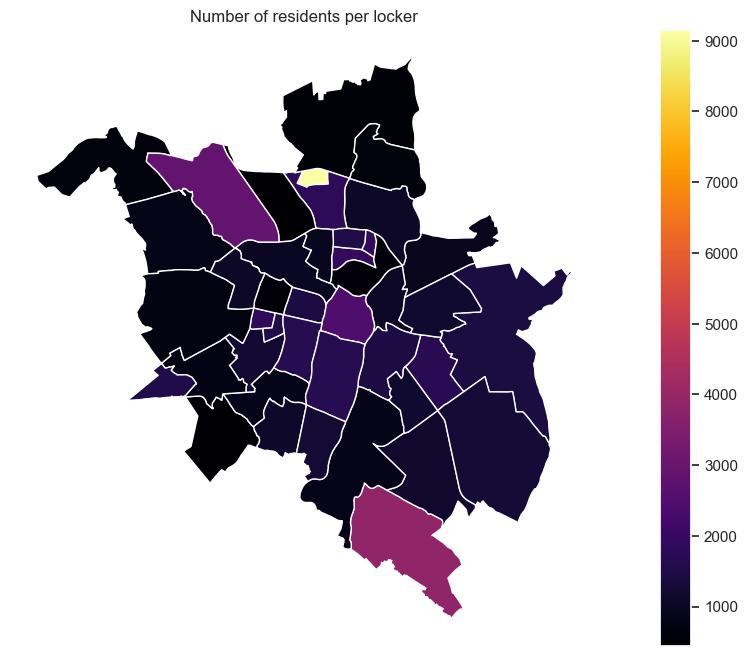

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,8)})

res_per_locker_map = combined.plot(column='res_per_locker', legend=True, cmap='inferno')
res_per_locker_map.set_axis_off()
res_per_locker_map.set_title('Number of residents per locker')

[Text(0.5, 1.0, 'Number of residents per locker')]

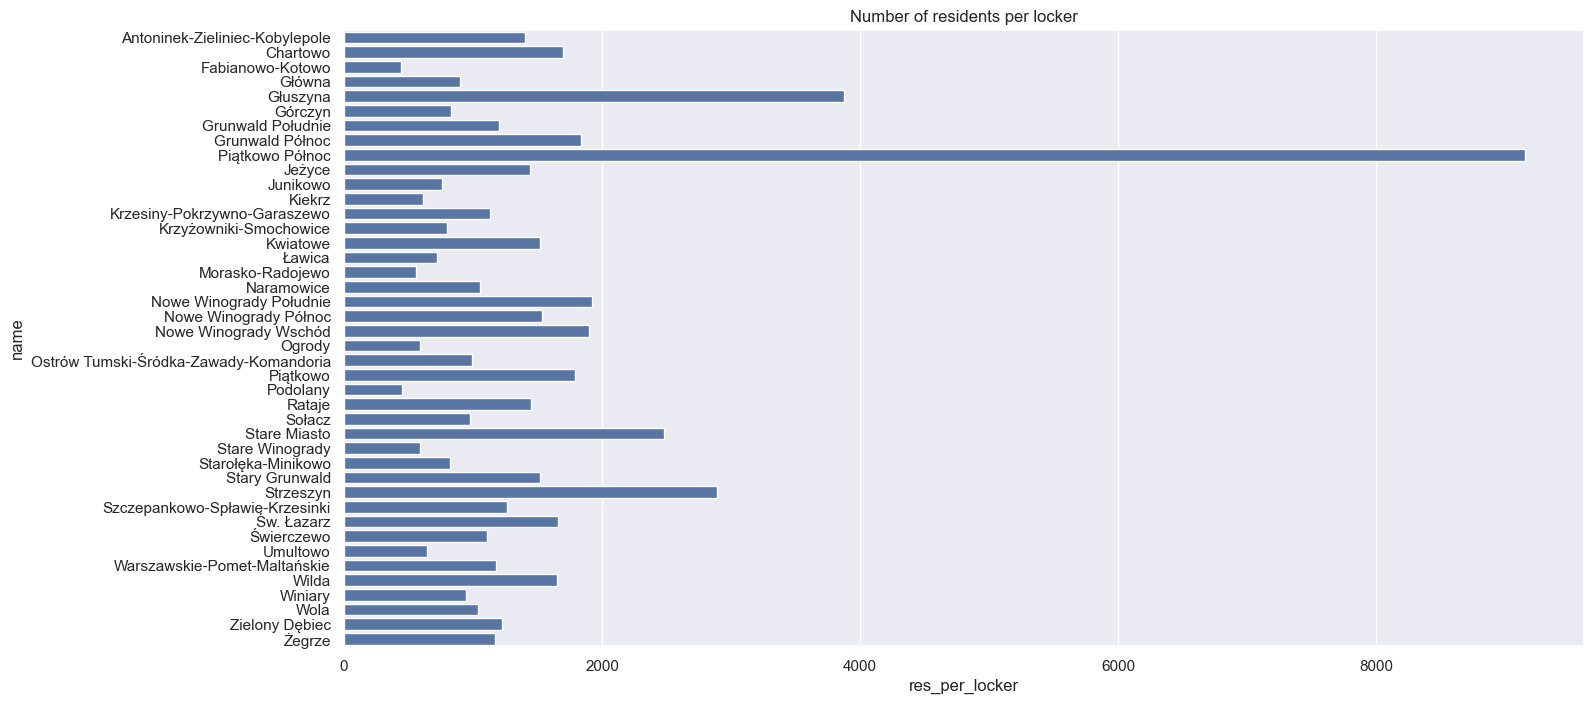

In [12]:
sns.barplot(combined, y='name', x='res_per_locker').set(title="Number of residents per locker")

In [21]:
print("Estates with high number of residents per locker: ")
combined[combined['res_per_locker'] > 2000]['name']

Estates with high number of residents per locker: 


4            Głuszyna
8     Piątkowo Północ
27       Stare Miasto
31          Strzeszyn
Name: name, dtype: object

[Text(0.5, 1.0, 'Number of lockers in particular estates')]

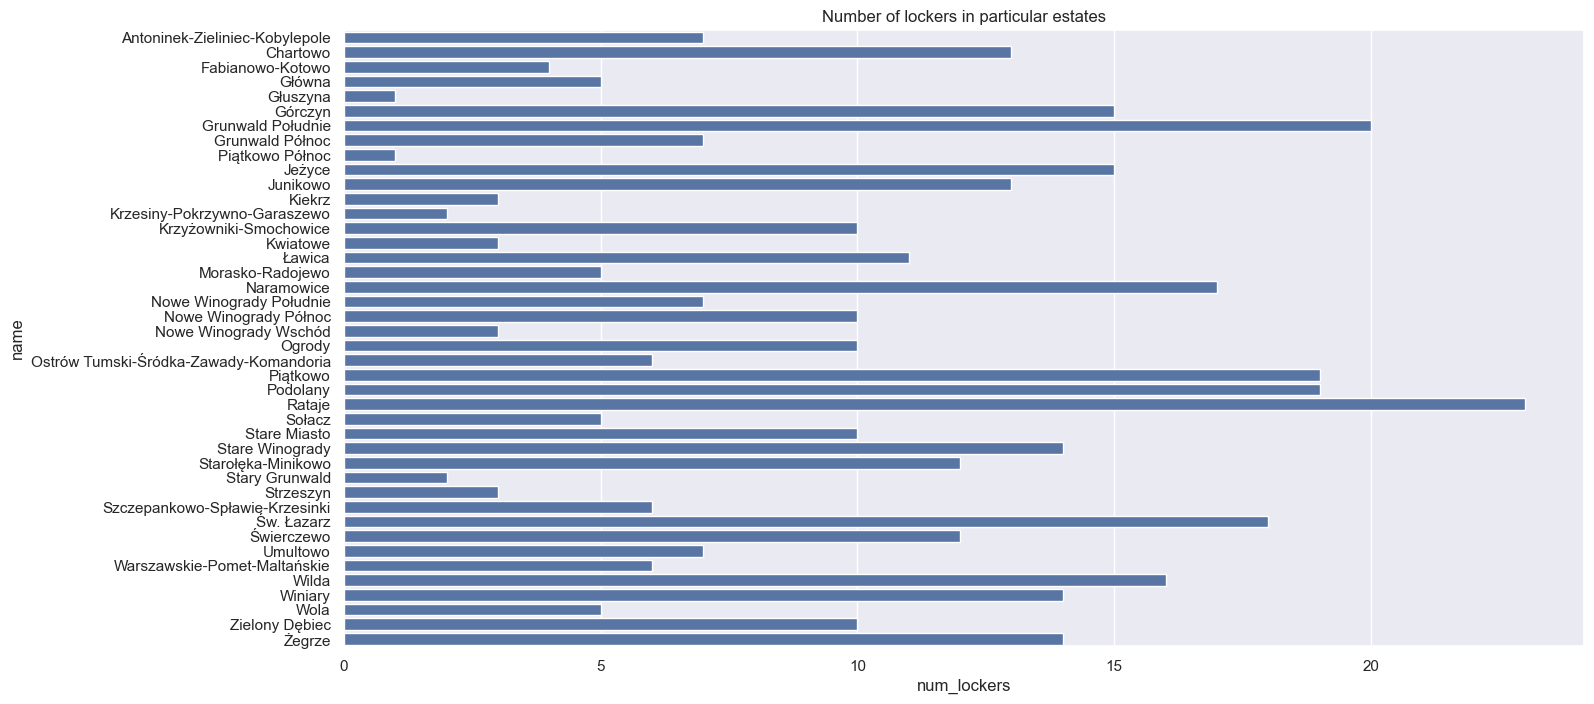

In [13]:
sns.barplot(combined, y='name', x='num_lockers').set(title="Number of lockers in particular estates")

In [14]:
poznan_parcel_lockers = None
for id, row in estates.iterrows():
    poznan_parcel_lockers = pd.concat([poznan_parcel_lockers, parcel_lockers[lockers_in_estates.iloc[id]]], axis=0)


In [16]:
import re
grocery_store_cond = poznan_parcel_lockers['description'].str.contains(r'([mM]ark|[sS]kle|[Ll]id|[Pp]olsk|[Nn]ett)', regex=True)
parking_cond = poznan_parcel_lockers['description'].str.contains(r'([pP]arking)', regex=True)
building_cond = poznan_parcel_lockers['description'].str.contains(r'([Bb]udy)', regex=True)
petrol_station_cond = poznan_parcel_lockers['description'].str.contains(r'([Ss]tac)', regex=True)
mansion_cond = poznan_parcel_lockers['description'].str.contains(r'([Pp]ose|[Bb]lok)', regex=True)

grocery_store = poznan_parcel_lockers[grocery_store_cond]['description'].shape[0]
parking = poznan_parcel_lockers[ ~grocery_store_cond & parking_cond]['description'].shape[0]
building = poznan_parcel_lockers[ ~grocery_store_cond & ~parking_cond & building_cond]['description'].shape[0]
petrol_station = poznan_parcel_lockers[ ~grocery_store_cond & ~building_cond & petrol_station_cond]['description'].shape[0]
mansion = poznan_parcel_lockers[ ~grocery_store_cond & ~building_cond & ~petrol_station_cond & ~parking_cond & mansion_cond].shape[0]

common_locations = pd.DataFrame({
    "Grocery store": [grocery_store],
    "Parking": [parking],
    "Petrol Station": [petrol_station],
    "Mansion": [mansion],
    "Other": [poznan_parcel_lockers[~grocery_store_cond & ~building_cond & ~petrol_station_cond & ~parking_cond & ~mansion_cond].shape[0]]
})



C:\Users\Hubert\AppData\Local\Temp\ipykernel_15052\1689251452.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  grocery_store_cond = poznan_parcel_lockers['description'].str.contains(r'([mM]ark|[sS]kle|[Ll]id|[Pp]olsk|[Nn]ett)', regex=True)
C:\Users\Hubert\AppData\Local\Temp\ipykernel_15052\1689251452.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  parking_cond = poznan_parcel_lockers['description'].str.contains(r'([pP]arking)', regex=True)
C:\Users\Hubert\AppData\Local\Temp\ipykernel_15052\1689251452.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  building_cond = poznan_parcel_lockers['description'].str.contains(r'([Bb]udy)', regex=True)
C:\Users\Hubert\AppData\Local\Temp\ipykernel_15052\1689251452.py:5: UserWarn

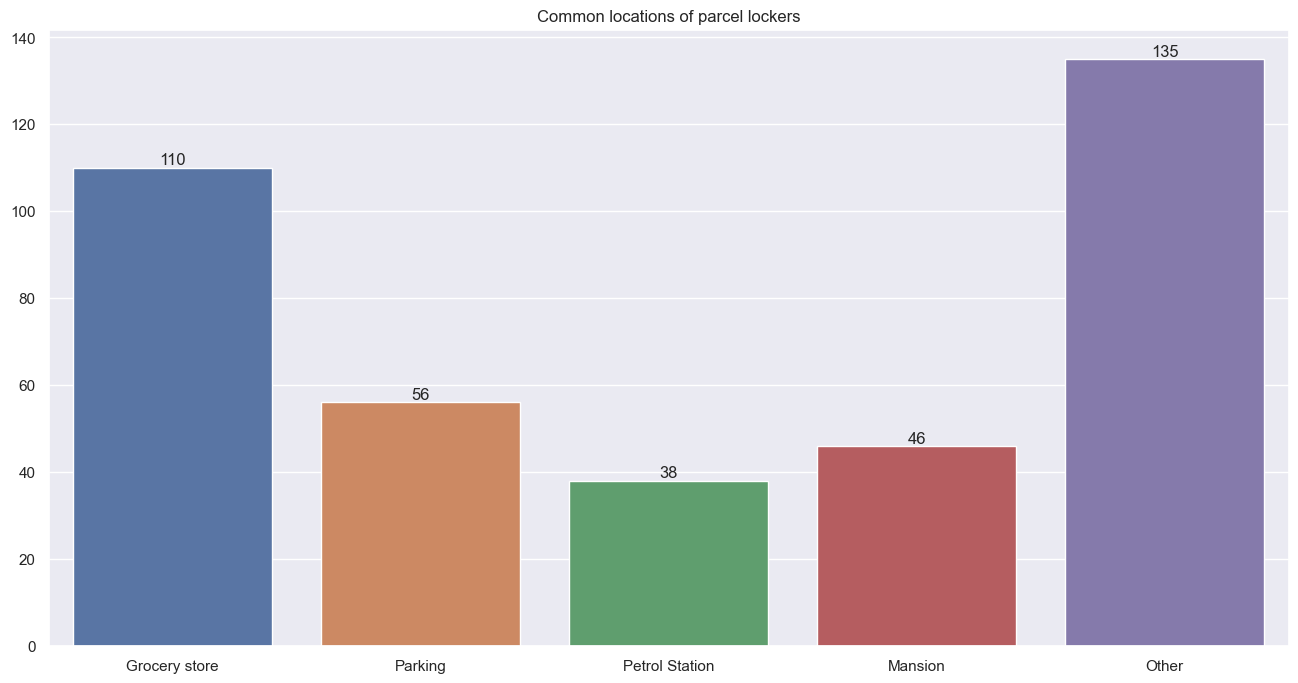

In [17]:
common_plot = sns.barplot(common_locations)
common_plot.set(title='Common locations of parcel lockers')

for container in common_plot.containers:
    common_plot.bar_label(container)

## Conclusions and further analysis

We can see some interesting trends:
 - `res_per_locker` is usually less than **2000**, this may mean that estates with this metric above 2000 should have more parcel lockers than currently or that the demand for parcel lockers is lower there
 - the most common locations of parcel lockers is near grocery stores, so it may mean that customers usually prefer that location


To explore these trends more and see if they are true, more data like:
 - location of customers' orders
 - amount of orders (prefarable timeline is around the holidays like: christmas to see the greatest usage of parcel lockers is particular area)
 - to estimate new locations of parcel lockers, some computer vision models would be useful to predict the area of buildings, so the estimation of the location for new parcel locker would not be for example in the middle of the lake 
